In [99]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from data_preprocessing import *
from model import *

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, Dropout, Flatten, Bidirectional, Conv1D 
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D 
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.2.0


In [11]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [12]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [13]:
def clean_text(text):
    #Removing unprintable characters
    text = ''.join(x for x in text if x.isprintable())

    # Cleaning the urls
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Cleaning the html elements
    text = re.sub(r'<.*?>', '', text)

    # Removing the punctuations
    text = re.sub('[!#?,.:";-@#$%^&*_~<>()-]', '', text)
    
    text = " ".join(word.lower() for word in text.split())
    return text

In [14]:
x_train = training_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [15]:
y_train, y_val = label_encoder(y_train, y_val)

In [16]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [17]:
pad_len=100
padding_type='post'
truncating_type='post'

In [18]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(x_train, x_val)

In [19]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [ ]:
dump(tokenizer, "../tokenizers/DL-raw-tokenizer-100.pk1")

In [20]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [21]:
vocab = tokenizer.word_index

# Domain Specific Fasttext Embeddings

In [26]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.raw.ft.skipgram.d300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

51245
Total time taken:  4.894547796999998


(52576, 300)

In [27]:
input_dim1 = embedding_matrix1.shape[0]
embedding_dim1 = 300
input_len = pad_len
print("Input dimension 1: ", input_dim1)
print("Embedding dimensions 1: ", embedding_dim1)
print("Input sentence dimensions 1: ", input_len)

Input dimension 1:  52576
Embedding dimensions 1:  300
Input sentence dimensions 1:  100


# Indic-Fasttext Embeddings

In [28]:
start = process_time()
embedding_path2 = "/home/eastwind/word-embeddings/fasttext/indicnlp.ft.mr.300.vec"
embedding_matrix2 = get_embedding_matrix(embedding_path2, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix2.shape

29684
Total time taken:  8.321486321000002


(52576, 300)

In [29]:
input_dim2 = embedding_matrix2.shape[0]
embedding_dim2 = 300
input_len = pad_len
print("Input dimension 2: ", input_dim2)
print("Embedding dimensions 2: ", embedding_dim2)
print("Input sentence dimensions 2: ", input_len)

Input dimension 2:  52576
Embedding dimensions 2:  300
Input sentence dimensions 2:  100


# Domain Specific + Indic-Fasttext Multi-channel CNN Architecture

In [64]:
# Input 1(Domain Specific Fasttext Embeddings):
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim1, output_dim=embedding_dim1, weights=[embedding_matrix1], trainable=False)(Input1)
Conv1 = Conv1D(filters=128, kernel_size=5, activation='relu')(Embedding_layer1)
MaxPooling1 = MaxPooling1D(pool_size=3)(Conv1)
Dropout1 = Dropout(0.2)(MaxPooling1)
Flatten1 = Flatten()(Dropout1)

# Input 2 (Indic-Fasttext Embeddings):
Input2 = Input(shape=(input_len,))
Embedding_layer2 = Embedding(input_dim=input_dim2, output_dim=embedding_dim2, weights=[embedding_matrix2], trainable=False)(Input2)
Conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(Embedding_layer2)
MaxPooling2 = MaxPooling1D(pool_size=3)(Conv2)
Dropout2 = Dropout(0.2)(MaxPooling2)
Flatten2 = Flatten()(Dropout2)

Merged = concatenate([Flatten1, Flatten2])
Dense1 = Dense(512, activation='relu')(Merged)
Dropout3 = Dropout(0.3)(Dense1)
Dense2 = Dense(32, activation='relu', kernel_regularizer=l2(0.015))(Dropout3)
output = Dense(4, activation='softmax')(Dense2)

classifier = Model(inputs=[Input1, Input2], outputs=output)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 100, 300)     15772800    input_32[0][0]                   
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 100, 300)     15772800    input_33[0][0]                   
___________________________________________________________________________________________

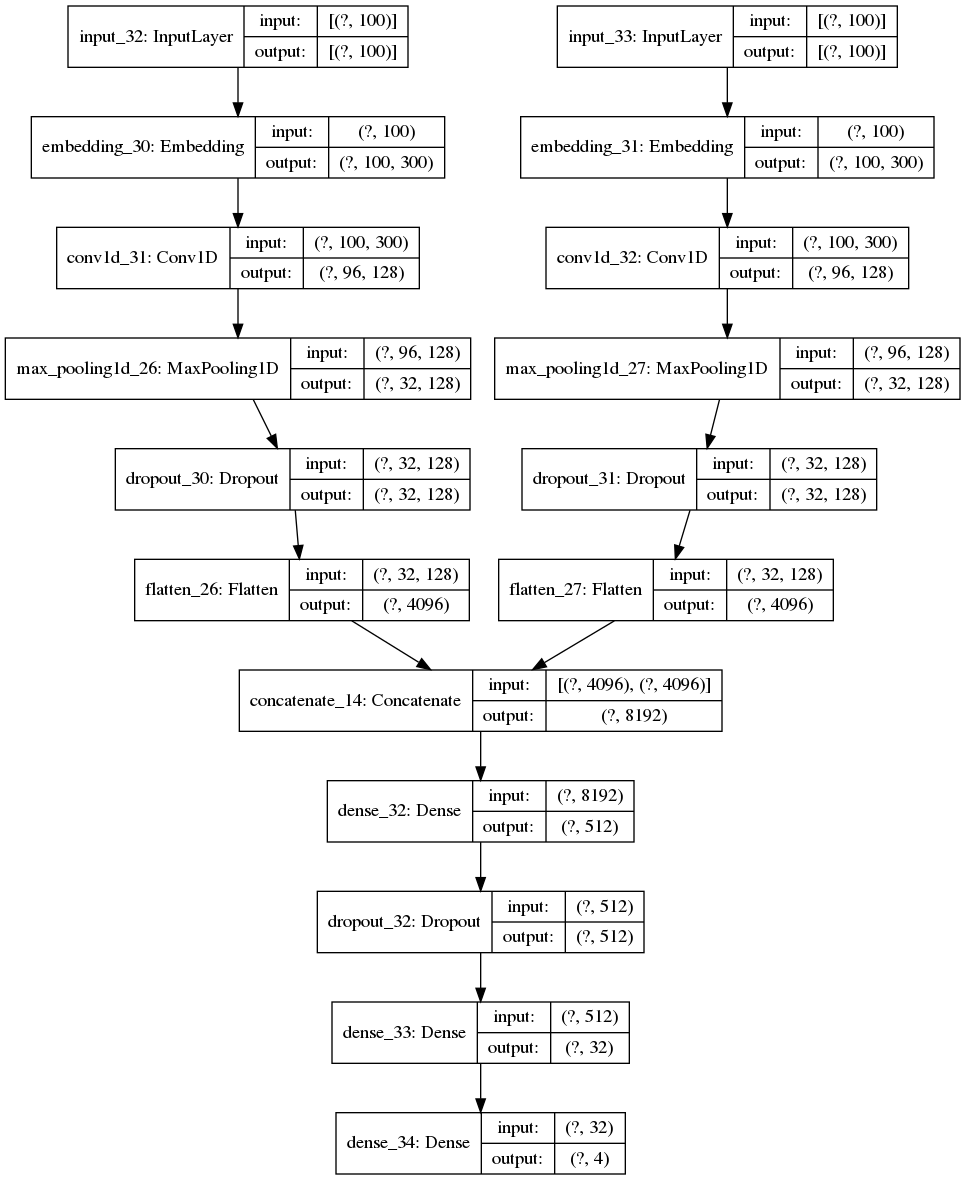

In [65]:
plot_model(classifier, show_shapes=True, to_file='multichannel.png')

In [66]:
history = classifier.fit([x_train_padded, x_train_padded], 
                         y_train, 
                         epochs=8,
                         batch_size=128,
                         verbose=1,
                         validation_data=([x_val_padded, x_val_padded], y_val))

Epoch 1/8
329/329 [==============================] - 110s 334ms/step - loss: 0.7228 - acc: 0.7806 - val_loss: 0.4461 - val_acc: 0.8532
Epoch 2/8
329/329 [==============================] - 111s 337ms/step - loss: 0.3486 - acc: 0.8833 - val_loss: 0.4001 - val_acc: 0.8616
Epoch 3/8
329/329 [==============================] - 111s 338ms/step - loss: 0.2469 - acc: 0.9211 - val_loss: 0.3903 - val_acc: 0.8698
Epoch 4/8
329/329 [==============================] - 115s 348ms/step - loss: 0.1664 - acc: 0.9495 - val_loss: 0.4242 - val_acc: 0.8677
Epoch 5/8
329/329 [==============================] - 120s 365ms/step - loss: 0.1097 - acc: 0.9698 - val_loss: 0.4660 - val_acc: 0.8735
Epoch 6/8
329/329 [==============================] - 121s 366ms/step - loss: 0.0810 - acc: 0.9780 - val_loss: 0.5108 - val_acc: 0.8632
Epoch 7/8
329/329 [==============================] - 121s 368ms/step - loss: 0.0650 - acc: 0.9837 - val_loss: 0.5513 - val_acc: 0.8669
Epoch 8/8
329/329 [==============================] - 12

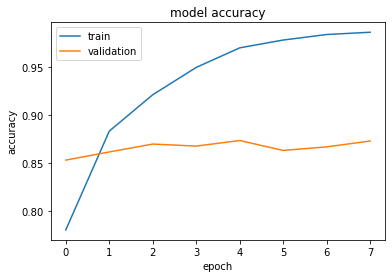

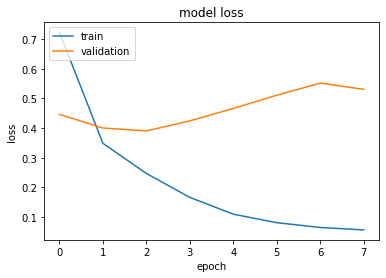

In [67]:
plot_curves(history)

In [68]:
results1 = np.argmax(classifier.predict([x_val_padded, x_val_padded]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.873015873015873

Precision:  [0.83123426 0.86683261 0.91727494 0.86268344]
Average Precision:  0.8695063103994282

Recall:  [0.78571429 0.9255814  0.8519774  0.84845361]
Average Recall:  0.8529316726101223

F1-Score:  [0.80783354 0.89524422 0.88342121 0.85550936]
Average F1-Score:  0.8605020788937269


In [70]:
save_model(classifier, "multi-channel-CNN/multi-channel-CNN-valacc-8730")

# LSA Embeddings

In [94]:
start = process_time()
embedding_path3 = "/home/eastwind/word-embeddings/LSA/TechDofication.LSA.mr.cleaned.d4.vec"
embedding_matrix3 = get_embedding_matrix(embedding_path3, vocab, embedding_dim=4)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix3.shape

52473
Total time taken:  0.3552200969988917


(52576, 4)

In [95]:
input_dim3 = embedding_matrix3.shape[0]
embedding_dim3 = embedding_matrix3.shape[1]
input_len = pad_len
print("Input dimension 3: ", input_dim3)
print("Embedding dimensions 3: ", embedding_dim3)
print("Input sentence dimensions 3: ", input_len)

Input dimension 3:  52576
Embedding dimensions 3:  4
Input sentence dimensions 3:  100


# Domain Specific + LSA Multi-channel CNN Architecture

In [103]:
# Input 1(Domain Specific Fasttext Embeddings):
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim1, output_dim=embedding_dim1, weights=[embedding_matrix1], trainable=False)(Input1)
Conv1 = Conv1D(filters=128, kernel_size=5, activation='relu')(Embedding_layer1)
MaxPooling1 = MaxPooling1D(pool_size=3)(Conv1)
Dropout1 = Dropout(0.2)(MaxPooling1)
Flatten1 = Flatten()(Dropout1)

# Input 2 (Indic-Fasttext Embeddings):
Input3 = Input(shape=(input_len,))
Embedding_layer3 = Embedding(input_dim=input_dim3, output_dim=embedding_dim3, weights=[embedding_matrix3], trainable=False)(Input3)
MaxPooling3 = GlobalAveragePooling1D()(Embedding_layer3)

Dense1 = Dense(512, activation='relu')(Flatten1)
Dropout_out = Dropout(0.3)(Dense1)
Dense2 = Dense(32, activation='relu', kernel_regularizer=l2(0.015))(Dropout_out)
Merged = concatenate([Dense2, MaxPooling3])
output = Dense(4, activation='softmax')(Merged)

classifier2 = Model(inputs=[Input1, Input3], outputs=output)
classifier2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier2.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_58 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_56 (Embedding)        (None, 100, 300)     15772800    input_58[0][0]                   
__________________________________________________________________________________________________
conv1d_46 (Conv1D)              (None, 96, 128)      192128      embedding_56[0][0]               
__________________________________________________________________________________________________
max_pooling1d_46 (MaxPooling1D) (None, 32, 128)      0           conv1d_46[0][0]                  
___________________________________________________________________________________________

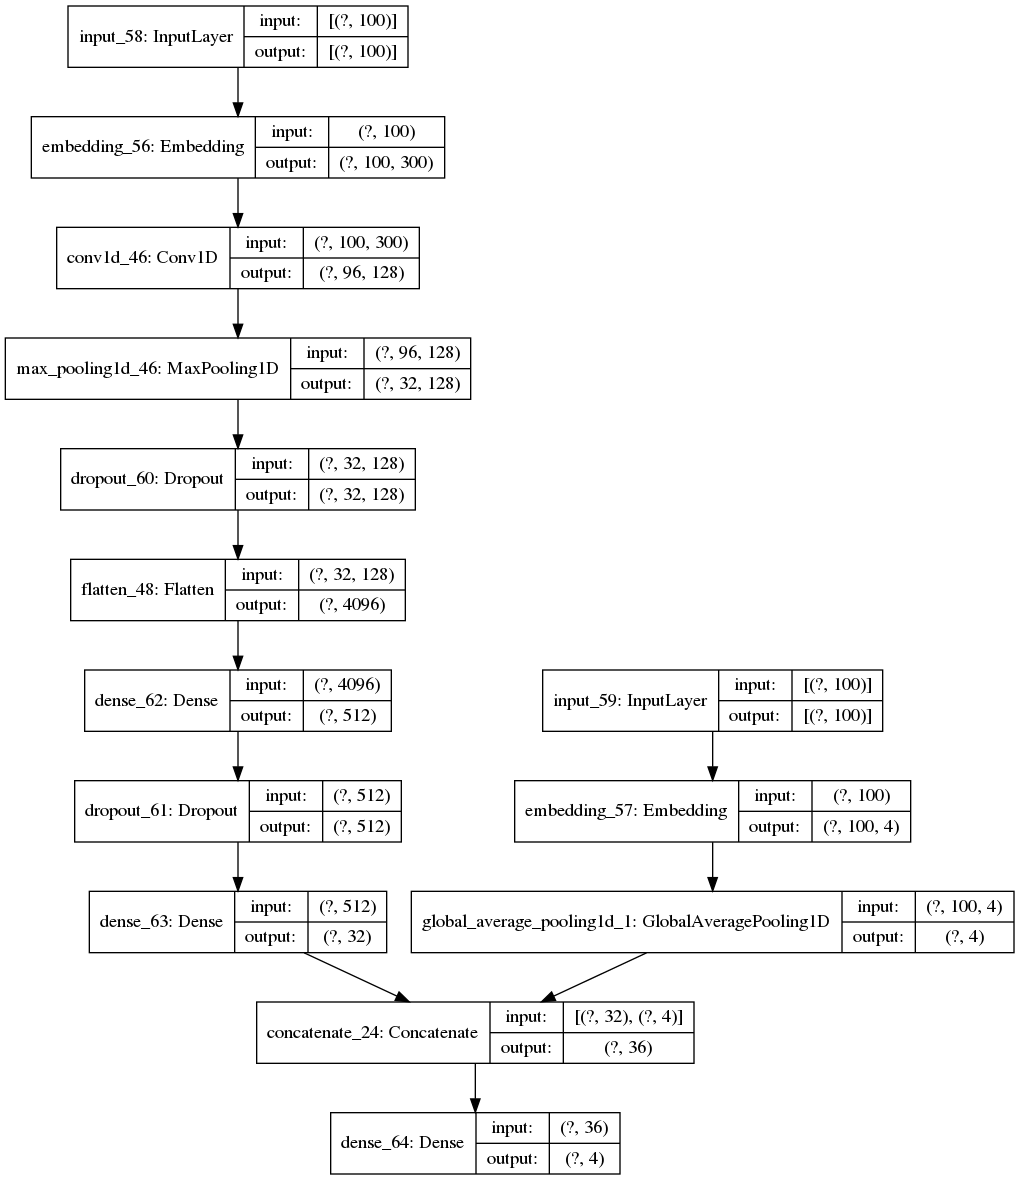

In [104]:
plot_model(classifier2, show_shapes=True, to_file='multichannel.png')

In [105]:
history2 = classifier2.fit([x_train_padded, x_train_padded], 
                           y_train, 
                           epochs=5,
                           batch_size=128,
                           verbose=1,
                           validation_data=([x_val_padded, x_val_padded], y_val))

Epoch 1/5
329/329 [==============================] - 88s 267ms/step - loss: 0.6965 - acc: 0.7952 - val_loss: 0.4374 - val_acc: 0.8519
Epoch 2/5
329/329 [==============================] - 83s 253ms/step - loss: 0.3602 - acc: 0.8795 - val_loss: 0.3980 - val_acc: 0.8643
Epoch 3/5
329/329 [==============================] - 78s 238ms/step - loss: 0.2703 - acc: 0.9127 - val_loss: 0.3898 - val_acc: 0.8712
Epoch 4/5
329/329 [==============================] - 86s 261ms/step - loss: 0.1929 - acc: 0.9420 - val_loss: 0.5022 - val_acc: 0.8452
Epoch 5/5
329/329 [==============================] - 88s 266ms/step - loss: 0.1408 - acc: 0.9581 - val_loss: 0.4666 - val_acc: 0.8519


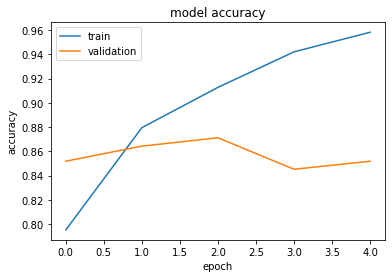

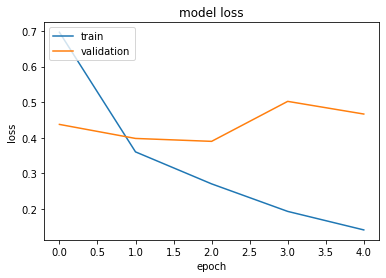

In [106]:
plot_curves(history2)

In [107]:
results2 = np.argmax(classifier2.predict([x_val_padded, x_val_padded]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8518518518518519

Precision:  [0.78738318 0.87709872 0.8495671  0.84345048]
Average Precision:  0.8393748700865605

Recall:  [0.80238095 0.86777409 0.88700565 0.81649485]
Average Recall:  0.8434138834595073

F1-Score:  [0.79481132 0.87241149 0.86788281 0.8297538 ]
Average F1-Score:  0.8412148540954717


In [ ]:
save_model(classifier, "multi-channel-CNN-valacc-8730")

In [1]:
import re

In [21]:
def token(sentence, remove_vowels=False, remove_repeat=False, minchars=2):
    tokens = []
#   for t in re.findall("[A-Z]{2,}(?![a-z])|[A-Z][a-z]+(?=[A-Z])|[\w]+",sentence.lower()):
    for t in re.findall(r"\w{1,}",sentence.lower()):

        if len(t)>=minchars:
            if remove_vowels:
                t=removeVovels(t)
            if remove_repeat:
                t=removeRepeat(t)
            tokens.append(t)
    return tokens

VOWELS = ['a', 'e', 'i', 'o', 'u']

def removeRepeat(string):
    return re.sub(r'(.)\1+', r'\1\1', string)     

def removeVovels(string):
    return ''.join([l for l in string.lower() if l not in VOWELS])